In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
import re
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('final_df.csv')

# Feature Engineering

In [3]:
df = df.dropna(subset=['weather_temperature'])
df = df.drop(columns=['weather_humidity','weather_detail','stadium_address','stadium_weather_station_code',
                      'stadium_weather_type','STATION','ELEVATION'])
df.drop(columns=['score_home','score_away', 'stadium_location','total'],inplace=True)
df.drop('schedule_date', axis=1,inplace=True)

df['over_under_result'] = np.where(df['over_under_result'] == 'Over',1,0)
df['stadium_surface'] = np.where(df['stadium_surface'] == 'Grass',1,0)
df['schedule_playoff'] = list(map(int, df['schedule_playoff']))
df['stadium_neutral'] = list(map(int, df['stadium_neutral']))
df = pd.get_dummies(df, columns = ['stadium_type'], drop_first= True)
df = pd.get_dummies(df, columns = ['stadium_name'], drop_first= True)
df = pd.get_dummies(df, columns = ['team_home'], drop_first= True)
df = pd.get_dummies(df, columns = ['team_away'], drop_first= True)
df = pd.get_dummies(df, columns = ['team_favorite_id'], drop_first= True)

uint8_columns = list(df.select_dtypes('uint8').columns)

for colname in df.columns:
    if colname in uint8_columns:
        df[colname] = df[colname].astype(int)

# Feature Selection

In [4]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('over_under_result', axis=1) # grabs everything else but 'Default'

# Create target variable
y = df['over_under_result'] # y is the column we're trying to predict

In [5]:
np.abs(df.corr()['over_under_result']).sort_values(ascending=False)

over_under_result                           1.000000
weather_wind_mph                            0.043742
stadium_name_Cinergy Field                  0.026435
stadium_name_New Era Field                  0.026416
stadium_name_FirstEnergy Stadium            0.024609
                                              ...   
team_away_Washington Redskins               0.000248
team_away_Cleveland Browns                  0.000173
stadium_name_Cleveland Municipal Stadium    0.000120
stadium_open                                0.000096
stadium_name_M&T Bank Stadium               0.000021
Name: over_under_result, Length: 199, dtype: float64

In [6]:
corrs_dict={}
for col in X.columns:
    corr=y.corr(X[col])
    corrs_dict[corr]=col
    
sorted(corrs_dict.items(),reverse=True)

[(0.02643507765088869, 'stadium_name_Cinergy Field'),
 (0.026416287574825382, 'stadium_name_New Era Field'),
 (0.023824693598373855, 'team_away_San Diego Chargers'),
 (0.02267698602796424, 'team_favorite_id_GB'),
 (0.022233434271607625, 'team_home_Los Angeles Rams'),
 (0.021686128129850147, 'team_home_Tennessee Titans'),
 (0.020461361803612396, 'stadium_name_Mile High Stadium'),
 (0.020380118175394576, 'stadium_name_Nissan Stadium'),
 (0.019866963896616848, 'team_away_Indianapolis Colts'),
 (0.019401942995838185, 'team_favorite_id_DET'),
 (0.019259995276488473, 'schedule_playoff'),
 (0.01905794388098324, 'stadium_name_Anaheim Stadium'),
 (0.018970180894961983, 'team_favorite_id_LAR'),
 (0.018115757195356234, 'team_away_Green Bay Packers'),
 (0.016021391998387598, 'team_favorite_id_DEN'),
 (0.01547820305912302, 'team_favorite_id_TEN'),
 (0.015331177015877535, 'team_home_Denver Broncos'),
 (0.015285025033512398, 'team_home_Detroit Lions'),
 (0.014664346586771577, 'team_home_New Orleans S

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_(X):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif['Features'] = X.columns
    return vif
Vif = vif_(X)

Vif.sort_values('VIF',ascending=False)[:5]

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,Features
99,inf,team_home_Houston Oilers
75,inf,stadium_name_Sun Devil Stadium
73,inf,stadium_name_Sports Authority Field at Mile High
72,inf,stadium_name_Soldier Field
71,inf,stadium_name_Seattle Kingdome


# Baseline Model

In [8]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR

In [9]:
#Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=20)

In [10]:
# Scale the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = X.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = X.columns)

In [11]:
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV()

logreg.fit(X_train, y_train)

base_logred_train_pred = logreg.predict(X_train)
base_logred_test_pred = logreg.predict(X_test)


base_logreg_recall = metrics.recall_score(y_test, base_logred_test_pred)
base_logred_train_f1_score = f1_score(y_train, base_logred_train_pred)
base_logreg_test_f1_score = f1_score(y_test, base_logred_test_pred)


print('Train F1 score: ', base_logred_train_f1_score)
print('Test F1 score: ', base_logreg_test_f1_score)

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Train F1 score:  0.5191489361702127
Test F1 score:  0.4800923254472014


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


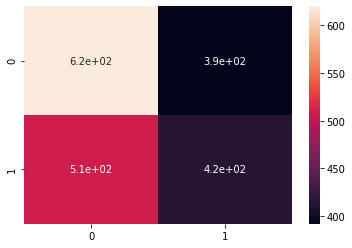

In [12]:
cm = confusion_matrix(y_test,base_logred_test_pred)
sns.heatmap(cm,annot=True);

## Decision Tree

In [14]:
# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

clf = DecisionTreeClassifier(random_state=1, criterion = 'gini', max_depth = 7, min_samples_leaf = 7, min_samples_split = 2)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

clf_f1_train = round(f1_score(y_train, y_pred_train), 3)
clf_f1_test = round(f1_score(y_test, y_pred), 3)
clf_recall = round(metrics.recall_score(y_test, y_pred), 3)

print('Train F1 score: ', clf_f1_train)
print('Test F1 score: ', clf_f1_test)

Recall Score:  0.375
Train F1 score:  0.487
Test F1 score:  0.424


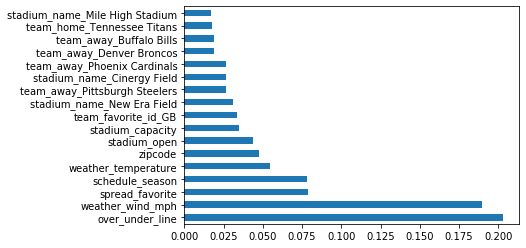

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

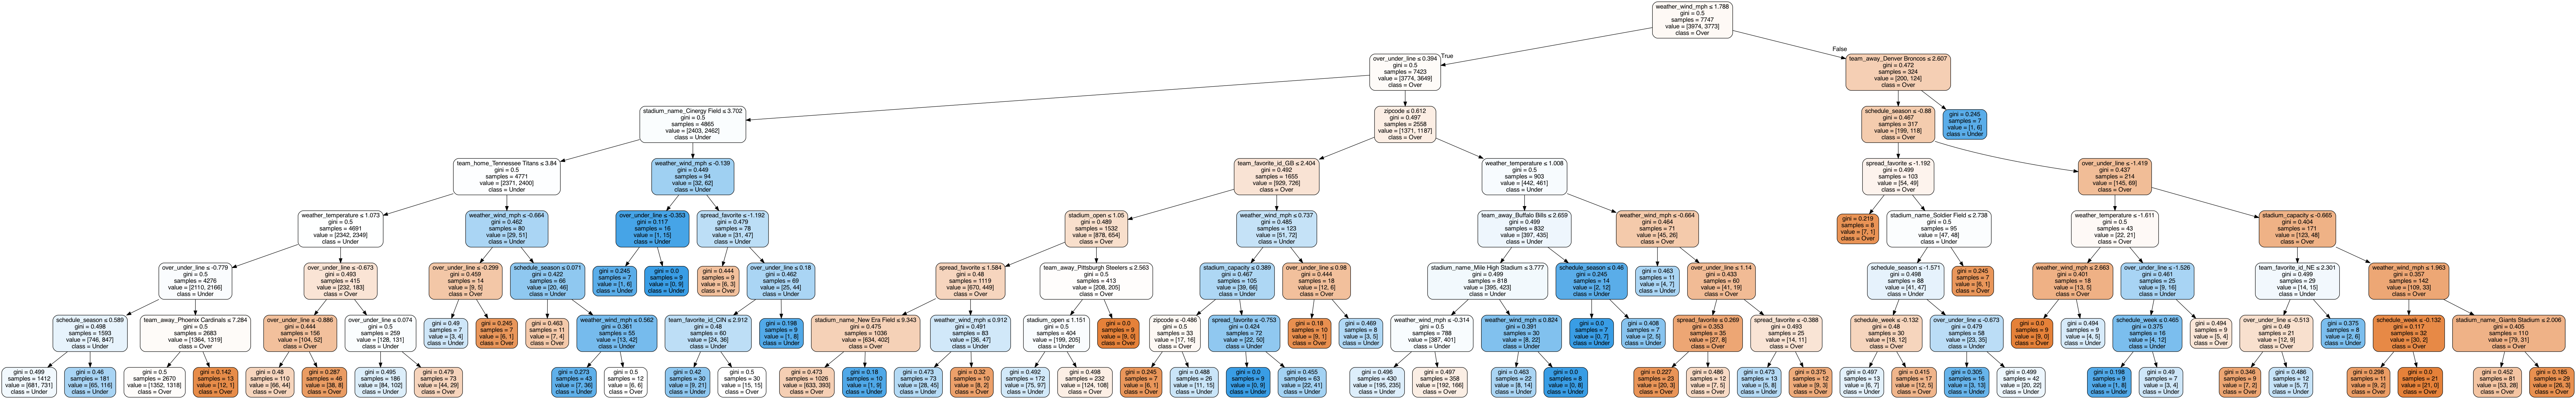

In [17]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['Over','Under'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())